# Softmax Regression

This notebook explores the softmax regression classification algorithm.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.optimize

In [2]:
penguins = pd.read_csv("../datasets/penguins_size.csv")
penguins

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,FEMALE
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,MALE
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,FEMALE


In [3]:
m = 344  # Number of points to use

features = np.array([
	penguins["culmen_length_mm"][:m],
	penguins["flipper_length_mm"][:m],
])

X = np.vstack((np.ones(m)[np.newaxis], features)).T
y = pd.Categorical(penguins["species"]).codes[:m]

keep_idx = np.argwhere(np.isfinite(X[:, 1]) & np.isfinite(X[:, 2])).flatten()
X = X[keep_idx]
y = y[keep_idx]

m = len(y)
K = len(np.unique(y))
n = X.shape[1] - 1  # Number of features

# One-hot encoding
Y = np.zeros((m, K))
Y[np.arange(m), y] = 1

print(f"{X.shape = }")
print(f"{Y.shape = }")
print(f"{m = }")
print(f"{K = }")
print(f"{n = }")

X.shape = (342, 3)
Y.shape = (342, 3)
m = 342
K = 3
n = 2


Softmax regression (aka multinomial logistic regression) is a generalization of logistic regression suitable for classification problems with more than two classes. In other words, the response variable $y$ can be equal to any of $\{1, \dots, K\}$ corresponding to a class label. The response variable is still discrete.

In practice there are two ways to encode the true class. Often, for each data point, the class is encoded as a vector of $K - 1$ zeros and $1$ one at the appropriate class index. This is known as **one-hot encoding**. The second way is to simply have the class numerical label at each index of the labels array, i.e. each $y^{(i)}$ can be one of $\{1, \dots, K\}$. This second way is known as **label encoding**. One-hot encoding is commonly used for softmax regression because the label vector can be naturally thought of as probability mass for each class.

The assumption for this model is that each class $k \in \{1,\dots,K\}$ has its own vector of parameters $\theta_k \in \mathbb{R}^{n + 1}$. The matrix $\theta$ is therefore of dimensions $K \times (n + 1)$. Each column in this matrix defines a line (or a hyperplane, in general), parameterized by $\theta_k^\top x = 0$, that separates the space into two regions: one where $\theta_k^\top x > 0$ (associated with class $k$), and one where $\theta_k^\top x < 0$ (not associated with $k$).

Just like with logistic regression, we would like to interpret the output as probability, so we need to plug $\theta_k^\top x$ (that is in so-called **logit space** and can be any real number) into some sort of function $\sigma(z_k)$ such that its range is $[0, 1]$ and $\sum_{k=1}^K \sigma(z_k)= 1$. This can easily be done in just two steps:
1. Exponentiate the result of the dot product: $\exp(\theta_k^\top x)$, such that we only have positive values.
2. Normalize the results by dividing by the sum over all classes, such that the sum is now $1$.

This is the role of the softmax function in softmax regression.
$$
\sigma(z_k) = \frac{\exp(z_k)}{\sum_{j=1}^K \exp(z_j)}
$$

When plugging in the dot product:
$$
\sigma(\theta_k^\top x) = \frac{\exp(\theta_k^\top x)}{\sum_{j=1}^K \exp(\theta_j^\top x)}
$$

Let's call the discrete distribution produced by the process $\hat p(y \vert x ; \theta)$. In the true distribution $p(y \vert x)$, equal to the indicator function $1\{y=k\}$, the probability mass for the correct class $k$ will be $1$, and that of all the incorrect classes will be $0$. Hence, the goal is rather simple: adjust the parameters to minimize the "distance" between two distributions, such that $\hat p(y \vert x; \theta)$ approaches the true distribution $p(y \vert x)$.

The formalization of the distance between two distributions is known as **cross-entropy loss**:
$$
H(p, \hat p) = - \sum_{k=1}^K P(y = k \vert x) \log \hat P(y = k \vert x;\theta)
$$

**Note**: $p(y \vert x)$ and $\hat p(y \vert x; \theta)$ are distributions; $P(y = k \vert x)$ and $P(y = k \vert x;\theta)$ are probabilities calculated for a specific class $k$. For brevity, we will annotate the latter as $p(y_k)$ and $\hat p(y_k)$ respectively:
$$
H(p, \hat p) = - \sum_{k=1}^K p(y_k) \log \hat p(y_k)
$$

Given that $p(y_k)$ is $1$ only for the correct class $t$, the cross-entropy for $x$ boils down to:
$$
H(p, \hat p)  = - \log \hat p(y_t) = - \log \frac{\exp(\theta_{t}^\top x)}{\sum_{j=1}^K \exp(\theta_j^\top x)}
$$

**Note**: cross-entropy is a special case of KL divergence, which is not a distance measure in a strict sense, since it's not symmetric, $H(p, q) \ne H(q, p)$ in a general case. However, it's still useful to think of it as such. The asymmetry is motivated by information theory. Nevertheless, the $-\log(x)$ function has a useful property: it heavily penalizes near-zero probability for the correct class.

Cross-entropy above is calculated for a single sample belonging to class $t$. The final cost function should consider all $m$ data points:
$$
J(\theta) = -\sum_{i = 1}^m \sum_{k=1}^K p(y_k^{(i)}) \log \hat p(y_k^{(i)})
= -\sum_{i = 1}^m \sum_{k=1}^K 1\{y^{(i)}=k\} \log \frac{\exp(\theta_k^T x^{(i)})}{\sum_{j = 1}^{K} \exp(\theta_j^T x^{(i)})}
$$

The gradient $\nabla_{\theta_k} J(\theta)$ can be found as:
$$
\nabla_{\theta_k} J(\theta) = - \sum_{i = 1}^m x^{(i)} \left(p(y_k^{(i)}) - \hat p(y_k^{(i)}) \right)
$$

This gives us a gradient for a single class $k$. The complete gradient would be a matrix of the same shape as $\theta$.

The derivation can be found [here](https://math.stackexchange.com/questions/2852620/how-do-you-take-the-gradient-vector-of-the-cross-entropy-cost-function). Alternatively, we can show that softmax regression is a GLM, and hence the form of the gradient is the same as in all GLMs.

Matrix form of both:
$$
\begin{gather*}
J(\theta) = - \sum_{\text{matrix}} \left[Y \odot \log(\sigma(X \theta^T))\right]\\
\nabla_{\theta_k} J(\theta) = - (Y - \sigma(X \theta^T))^T X\\
\end{gather*}
$$

where all functions are applied element-wise and $\odot$ denotes Hadamard product.

**Note**: it's fairly common to divide the loss by $m$ to keep it independent of the dataset size and minimize the chance of overflow.



In [4]:
def softmax(z):
	"""
	z: [K, ] or [m, K]

	Returns: [K, ] or [m, K]
	"""
	e = np.exp(z - np.max(z))  # Prevent overflow
	return e / np.sum(e, axis=-1, keepdims=True)


def loss(theta, X, Y, m, K):
	"""
	theta: [K, n + 1]
	X: [m, n + 1]
	Y: [m, K]
	m: scalar

	Returns: scalar
	"""
	sm = softmax(X @ theta.T)  # [m, K]
	return -np.sum(Y * np.log(sm)) / m


def gradient(theta, X, Y, m, K):
	"""
	theta: [K, n + 1]
	X: [m, n + 1]
	Y: [m, K]
	m: scalar

	Returns: [K, n + 1]
	"""
	sm = softmax(X @ theta.T)  # [m, K]
	return -((Y - sm).T @ X) / m


def __loss_flattened(theta, X, Y, m, K):
	"""
	Makes a call to loss. 
	Expects theta as a flattened parameter and returns a flattened result.
	"""
	theta = np.reshape(theta, (K, n + 1))
	return loss(theta, X, Y, m, K)


def __gradient_flattened(theta, X, Y, m, K):
	"""
	Makes a call to gradient. 
	Expects theta as a flattened parameter and returns a flattened result.
	"""
	theta = np.reshape(theta, (K, n + 1))
	return gradient(theta, X, Y, m, K).flatten()


In [5]:
initial_guesses = np.array([np.zeros(n + 1) for _ in range(K)]).ravel()

res = scipy.optimize.minimize(
    fun=__loss_flattened,
    x0=initial_guesses,
    args=(X, Y, m, K),
    jac=__gradient_flattened,
    method='BFGS'
)

theta = res.x.reshape(K, n + 1)
print(theta)

[[ 48.82021099  -0.60979815  -0.1043228 ]
 [ 22.21415886   0.73769004  -0.27398319]
 [-71.03436984  -0.12789189   0.37830599]]


In [6]:
probabilities = softmax(X @ theta.T)
predictions = np.argmax(probabilities, axis=-1)

n_correct = np.count_nonzero(predictions == y)
accuracy = n_correct / len(y)

print(f"{accuracy = :.4f}")

accuracy = 0.9591


To visualize the decision boundary, we will simply find the class, corresponding to the highest probability at each point of the space.

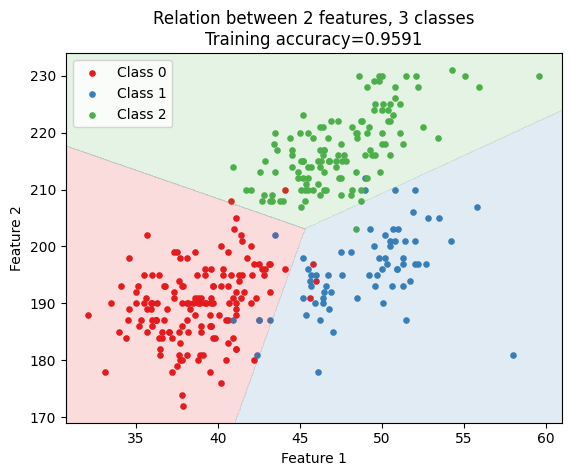

In [7]:
def plot_regions(colors, theta, x_limits, y_limits):
	x1_min, x1_max = x_limits[0], x_limits[1]
	x2_min, x2_max = y_limits[0], y_limits[1]
	x1_samples = 800
	x2_samples = 800

	x1 = np.linspace(x1_min, x1_max, x1_samples)
	x2 = np.linspace(x2_min, x2_max, x2_samples)
	xx1, xx2 = np.meshgrid(x1, x2)

	grid_points = np.stack((np.ones(x1_samples * x2_samples), xx1.ravel(), xx2.ravel())).T

	probabilities = softmax(grid_points @ theta.T)
	Z = np.argmax(probabilities, axis=-1)
	Z = Z.reshape(xx1.shape)

	plt.contourf(xx1, xx2, Z, levels=K - 1, alpha=0.15, colors=colors)


def plot_data(colors, X):
	for i, lbl in enumerate(np.unique(y)):
		plt.scatter(X[y == lbl, 1], X[y == lbl, 2], label=f'Class {lbl}', s=14, color=colors[i])


cm = plt.get_cmap("Set1")
colors = np.array([cm(i) for i in range(K)])

plot_data(colors, X)

ax = plt.gca()
plot_regions(colors, theta, ax.get_xlim(), ax.get_ylim())

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title(f"Relation between {n} features, {K} classes\nTraining accuracy={accuracy:.4f}")

plt.rcParams["figure.figsize"] = (8, 6)
plt.legend()
plt.show()